# Feature Engineering & Preprocessing

In [1]:
import pickle
import re
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import boxcox, yeojohnson
import nltk
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN

# Connect tqdm to pandas
tqdm.pandas()

pd.set_option('display.max_rows', 400)
pd.set_option('max_colwidth', 50)
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_pickle(f'./datasets/train.pickle')

In [3]:
n_comments = train['n_comments']

In [4]:
train = train.drop(columns=['n_comments'])

In [5]:
test = pd.read_pickle('./datasets/test.pickle')

### Summary of Variables Created

In this notebook, I created a significant number of additional features including:

- Box-cox transformation of word count
- Time variables based on publication date
    - Day of week, day of month, hour, weekend
    - Number of articles posted per day
- Keywords
    - Donald Trump
    - Republican / Democrat news
    - COVID-19
- Headline / abstract length
- Whether headline / abstract contains a question mark 
- Categorical features transformed into ordinal features based on average popularity (newsdesk, section, subsection, material)
- Sentiment based on headline + abstract
    - Positive, neutral, negative and compound sentiment

## Word Count

We saw previously that the Boxcox transformation seems to work best, so we'll use that going forward. We'll also keep the original word count variable as removing it led to a drop in model accuracy.

In [6]:
section_avg = train.groupby('section').mean()['word_count']

In [7]:
train['boxcox_word'] = train['word_count'].apply(lambda x: 0.001 if x == 0 else x)
train['boxcox_word'] = boxcox(train['boxcox_word'])[0]

In [8]:
test['boxcox_word'] = test['word_count'].apply(lambda x: 0.001 if x == 0 else x)
test['boxcox_word'] = boxcox(test['boxcox_word'])[0]

## Time Variables

Time affects the frequency of published articles, which correspondingly affects the popularity of articles. Articles published at a time where less articles are published are more likely to be more popular -- there's less places for commentators to go.

In [9]:
train['day_of_month'] = train['pub_date'].apply(lambda x: x.day)
train['day_of_week'] = train['pub_date'].apply(lambda x: x.dayofweek)
train['hour'] = train['pub_date'].apply(lambda x: x.hour)
train['is_weekend'] = train['day_of_week'].apply(lambda x: 1 if x==5 or x==6 else 0)

In [10]:
test['day_of_month'] = test['pub_date'].apply(lambda x: x.day)
test['day_of_week'] = test['pub_date'].apply(lambda x: x.dayofweek)
test['hour'] = test['pub_date'].apply(lambda x: x.hour)
test['is_weekend'] = test['day_of_week'].apply(lambda x: 1 if x==5 or x==6 else 0)

I also created an additional variable that tracks when an article was published. Articles published between 10PM and 2AM seem to have to have a much higher average popularity.

In [11]:
train['is_primehour'] = train['hour'].apply(lambda x: 1 if x > 22 else 1 if x < 4 else 0)

In [12]:
train.corr()['is_popular']['is_primehour']

0.16983850369317796

In [13]:
test['is_primehour'] = test['hour'].apply(lambda x: 1 if x > 22 else 1 if x < 4 else 0)

### Articles Per Day

Similar to our time variables, I created a variable that tracks the number of articles posted in a day. The idea is that the less articles there are, the higher the popularity and vice versa.

In [14]:
train['group_date'] = train['pub_date'].astype(str).apply(lambda x: x[:10])
group_dates = train['group_date'].value_counts()
train['posts_per_day'] = train['group_date'].apply(lambda x: group_dates[x])

In [15]:
# More posts in a day correlated with lower popularity
train.corr()['is_popular'][['posts_per_day']]

posts_per_day   -0.1039
Name: is_popular, dtype: float64

In [16]:
test['group_date'] = test['pub_date'].astype(str).apply(lambda x: x[:10])
group_dates = test['group_date'].value_counts()
test['posts_per_day'] = test['group_date'].apply(lambda x: group_dates[x])

## Keywords

Having a certain number of keywords seems important -- the ideal number of keywords seems to be between 11 and 16. This could suggest that people are more interested in articles that cover a range of topics, people and organizations.

In [17]:
train['n_keywords'] = train['keywords'].apply(lambda x: len(x))
test['n_keywords'] = test['keywords'].apply(lambda x: len(x) if type(x) is list else 0)

In [18]:
train['ideal_n_keywords'] = train['n_keywords'].apply(lambda x: 1 if x == 1 else 1 if (x > 11 and x < 16) else 0)
test['ideal_n_keywords'] = test['n_keywords'].apply(lambda x: 1 if x == 1 else 1 if (x > 11 and x < 16) else 0)

In [19]:
train.corr()['is_popular'][['n_keywords', 'ideal_n_keywords']]

n_keywords          0.072866
ideal_n_keywords    0.143074
Name: is_popular, dtype: float64

### Trump / Republican / Democrat

We saw that Donald Trump and Republican/Democrat keywords are among the most frequent keywords, so we'll create a variable here to keep track of that. Both these features have a significant correlation with popularity.

In [20]:
train['is_trump'] = train['keywords'].apply(lambda x: 1 if 'Trump, Donald J' in x else 0)

test['is_trump'] = test['keywords'].apply(lambda x: 0 if type(x) is not list 
                                          else (1 if 'Trump, Donald J' in x else 0))

In [21]:
train['is_party'] = train['keywords'].apply(lambda x: 0 if type(x) is not list 
                                          else (1 if 'Democratic Party' in x 
                                                else 1 if 'Republican Party' in x else 0))

test['is_party'] = test['keywords'].apply(lambda x: 0 if type(x) is not list 
                                          else (1 if 'Democratic Party' in x 
                                                else 1 if 'Republican Party' in x else 0))

In [22]:
train.corr()['is_popular'][['is_trump', 'is_party']]

is_trump    0.273985
is_party    0.201494
Name: is_popular, dtype: float64

### Race & Ethnicity

Race and ethnicity has always been a hot topic in the US, and especially so this year with the death of George Floyd. This has a slight correlation with article popularity.

In [23]:
train['is_racial'] = train['keywords'].apply(lambda x: 0 if type(x) is not list 
                                          else (1 if 'Black People' in x 
                                                else 1 if 'Race and Ethnicity' in x 
                                                else 1 if 'Discrimination' in x
                                                else 1 if 'Black Lives Matter Movement' in x
                                                else 0))

test['is_racial'] = test['keywords'].apply(lambda x: 0 if type(x) is not list 
                                          else (1 if 'Black People' in x 
                                                else 1 if 'Race and Ethnicity' in x 
                                                else 1 if 'Discrimination' in x
                                                else 1 if 'Black Lives Matter Movement' in x
                                                else 0))

In [24]:
train.corr()['is_popular'][['is_racial']]

is_racial    0.062983
Name: is_popular, dtype: float64

### COVID-19

COVID-19 has drastically changed the world as we know it -- it was also the most frequent keyword in our entire dataset. All three features below have a faint correlation with popularity.

In [25]:
train['is_covid'] = train['keywords'].apply(lambda x: 0 if type(x) is not list 
                                          else (1 if 'Coronavirus (2019-nCoV)' in x \
                                                else 1 if 'Coronavirus Risks and Safety Concerns' in x 
                                                else 0))

test['is_covid'] = test['keywords'].apply(lambda x: 0 if type(x) is not list 
                                          else (1 if 'Coronavirus (2019-nCoV)' in x \
                                                else 1 if 'Coronavirus Risks and Safety Concerns' in x else 0))

In [26]:
train['is_epidemic'] = train['keywords'].apply(lambda x: 0 if type(x) is not list 
                                          else (1 if 'Epidemics' in x else 0))

test['is_epidemic'] = test['keywords'].apply(lambda x: 0 if type(x) is not list 
                                          else (1 if 'Epidemics' in x else 0))

In [27]:
train['is_death'] = train['keywords'].apply(lambda x: 1 if 'Deaths (Fatalities)' in x else 0)

test['is_death'] = test['keywords'].apply(lambda x: 0 if type(x) is not list else 1 if 'Deaths (Fatalities)' in x else 0)

In [28]:
train.corr()['is_popular'][['is_covid', 'is_epidemic', 'is_death']]

is_covid       0.071195
is_epidemic    0.069257
is_death       0.046664
Name: is_popular, dtype: float64

## Question

If the headline or abstract contains a question mark, there's a good chance that the article has been written in a way to invite commentary. Alternatively, people might view the question mark as a friendly invitation to comment.

In [29]:
train['headline_question'] = train['headline'].apply(lambda x: 1 if '?' in x else 0)
test['headline_question'] = test['headline'].apply(lambda x: 1 if '?' in x else 0)

In [30]:
train[train['headline_question'] == 1]['is_popular'].value_counts()

1    954
0    685
Name: is_popular, dtype: int64

In [31]:
train['abs_question'] = train['abstract'].apply(lambda x: 1 if '?' in x else 0)
test['abs_question'] = test['abstract'].apply(lambda x: 1 if '?' in x else 0)

In [32]:
train[train['abs_question'] == 1]['is_popular'].value_counts()

1    508
0    387
Name: is_popular, dtype: int64

In [33]:
train.corr()['is_popular'][['headline_question', 'abs_question']]

headline_question    0.065796
abs_question         0.039141
Name: is_popular, dtype: float64

## Newsdesk / Section / Subsection / Material

An article's newsdesk, section, subsection are likely the most powerful predictors of popularity. Opinion Editorials (OpEds) are much more likely to draw comments because they're likely written in a way to attract attention or controversy. These OpEds tackle recent events and issues, and attempt to formulate viewpoints based on an objective analysis of happenings and conflicting/contrary opinions. NYT Opinion pieces are also always open for comments, which would naturally increase the likelihood of having a popular article.

It was pretty difficult to decide on how to map / encode these features. There are 60 newsdesks, 42 sections, 67 subsections, and 10 types of material. Performing a one hot encoding on each variable would leave me with over 180 features in total.

There are several approaches that I tried:
- One hot encode Newsdesk, Section and Subsection (this returned poor results)
- Combine Newsdesk, Section and Subsection into a single `NewsType` variable 
    - For example: Foreign newsdesk, World section, Australia Subsection --> #Foreign#World#Australia.
    - Group similar articles together e.g. #Foreign#World#Australia and #Foreign#World#Asia Pacific. This naturally presents some difficulty though -- how do we decide which sections and subsections to group together? The Australia subsection has more popular articles but only has 46 articles compared to the 327 articles in the Asia Pacific subsection.
- Create an ordinal interaction feature (number of popular articles * total number of articles) that gives a higher weight to features that have many popular articles and a large number of total articles.
- Use DBSCAN or other clustering methods to group variables together.

Ultimately, I found that <b>taking a simpler approach returned better results</b>. Below, I created a function that groups features according to their average popularity. In short, I created an ordinal feature that places more weight on newsdesks/sections/subsections/materials that have an average popularity of 0.6 and above. Conversely, I placed a low weight on variables that have a average popularity of 0.4 and below.

To catch unique newsdesks/sections/subsections/materials that are in the test but not in train dataset, I added in an `if` statement that maps these unique sections to 0. This should cause our model to treat them in a neutral way.

In [34]:
# Combining newsdesks -- the different names reflect interactive articles that will be accounted for later
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'The Upshot' if x=='Upshot' else x)
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'OpEd' if x=='Opinion' else x)
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'AtHome' if x=='At Home' else x)

test['newsdesk'] = test['newsdesk'].apply(lambda x: 'The Upshot' if x=='Upshot' else x)
test['newsdesk'] = test['newsdesk'].apply(lambda x: 'OpEd' if x=='Opinion' else x)
test['newsdesk'] = test['newsdesk'].apply(lambda x: 'AtHome' if x=='At Home' else x)

In [35]:
# We have to fill the null values in our subsection
train['subsection'].fillna('N/A', inplace=True)
test['subsection'].fillna('N/A', inplace=True)

In [36]:
def map_popularity(col):
    df = train.groupby(f'{col}').mean().reset_index().sort_values(by='is_popular', ascending=False) \
              [[f'{col}', 'is_popular']]
    df.columns=[f'{col}', 'avg_popularity']
    
    pop_5 = df[df['avg_popularity'] >= 0.7][f'{col}'].values
    pop_4 = df[(df['avg_popularity'] < 0.7) & (df['avg_popularity'] >= 0.6)][f'{col}'].values
    pop_3 = df[(df['avg_popularity'] < 0.6) & (df['avg_popularity'] >= 0.5)][f'{col}'].values
    pop_2 = df[(df['avg_popularity'] < 0.5) & (df['avg_popularity'] >= 0.4)][f'{col}'].values
    pop_1 = df[(df['avg_popularity'] < 0.4) & (df['avg_popularity'] >= 0.3)][f'{col}'].values
    pop_0 = df[df['avg_popularity'] < 0.3][f'{col}'].values
    
    def lambda_fxn(x):
        if x in pop_5:
            return 5
        elif x in pop_4:
            return 4
        elif x in pop_3:
            return 3
        elif x in pop_2:
            return 2
        elif x in pop_1:
            return 1
        elif x in pop_0:
            return -1
        
        # To catch news desks/sections/subsections/material in test but not in train
        else:
            return 0
    
    train[f'{col}_pop'] = train[f'{col}'].apply(lambda_fxn)
    test[f'{col}_pop'] = test[f'{col}'].apply(lambda_fxn)

In [37]:
map_popularity('newsdesk')

In [38]:
map_popularity('section')

In [39]:
map_popularity('subsection')

In [40]:
map_popularity('material')

In [41]:
train.loc[0][['headline', 'newsdesk', 'newsdesk_pop', 'section', 'section_pop', 'subsection',
              'subsection_pop', 'material', 'material_pop']].to_frame().T

,headline,newsdesk,newsdesk_pop,section,section_pop,subsection,subsection_pop,material,material_pop
0,Protect Veterans From Fraud,Editorial,5,Opinion,5,N/A,3,Editorial,5


In [42]:
train.loc[101][['headline', 'newsdesk', 'newsdesk_pop', 'section', 'section_pop', 'subsection', 
                'subsection_pop', 'material', 'material_pop']].to_frame().T

,headline,newsdesk,newsdesk_pop,section,section_pop,subsection,subsection_pop,material,material_pop
101,‘Nowhere Else to Go’: Some Defy Warnings to Fl...,Foreign,2,World,3,Australia,3,News,2


## Other Features

In [43]:
train['combi_text'] = train['headline'] + '. ' + train['abstract']
train['combi_text2'] = train['combi_text'].str.replace(r'[\!?.]+[\.]+','.', regex=True) # remove extra punctuation in headline

test['combi_text'] = test['headline'] + '. ' + test['abstract']
test['combi_text2'] = test['combi_text'].str.replace(r'[\!?.]+[\.]+','.', regex=True)

### Sentiment

Sentiment plays a notable role in determining popularity. People are more likely to comment on articles with headlines that have negative sentiment, and less likely to comment on articles with headlines that have neutral sentiment. Previous [research](https://jonahberger.com/wp-content/uploads/2013/02/ViralityB.pdf) has shown that content that evokes high-arousal positive (awe) or negative (anger or anxiety) emotions tends to be more viral.

In [44]:
train['combi_text'][0]

'Protect Veterans From Fraud. Congress could do much more to protect Americans who have served their country from predatory for-profit colleges.'

In [45]:
# Instantiating sentiment intensity analyzer
sia = SIA()
sia.polarity_scores(train['combi_text'][0])

{'neg': 0.139, 'neu': 0.66, 'pos': 0.201, 'compound': 0.1725}

In [46]:
def get_sentiment(row):
    sentiment_dict = sia.polarity_scores(row['combi_text'])
    row['sentiment_pos'] = sentiment_dict['pos']
    row['sentiment_neu'] = sentiment_dict['neu']
    row['sentiment_neg'] = sentiment_dict['neg']
    row['sentiment_compound'] = sentiment_dict['compound']
    return row

In [47]:
train = train.progress_apply(get_sentiment, axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 12792/12792 [00:26<00:00, 476.11it/s]


In [48]:
train.loc[train['sentiment_pos'].sort_values(ascending=False).index]

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,is_popular,uniqueID,boxcox_word,day_of_month,day_of_week,hour,is_weekend,is_primehour,group_date,posts_per_day,n_keywords,ideal_n_keywords,is_trump,is_party,is_racial,is_covid,is_epidemic,is_death,headline_question,abs_question,newsdesk_pop,section_pop,subsection_pop,material_pop,combi_text,combi_text2,sentiment_pos,sentiment_neu,sentiment_neg,sentiment_compound
6976,OpEd,Opinion,N/A,Op-Ed,"We Should Help Workers, Not Kill Them",Unemployment benefits: an unheralded success s...,"[Coronavirus Reopenings, Unemployment, Coronav...",883,2020-05-18 22:00:07+00:00,1,nyt://article/440db8c2-dc0f-58f8-aebd-4ff00adf...,42.202049,18,0,22,0,0,2020-05-18,58,7,0,0,1,0,1,0,0,0,0,5,5,3,5,"We Should Help Workers, Not Kill Them. Unemplo...","We Should Help Workers, Not Kill Them. Unemplo...",0.654,0.346,0.000,0.9342
1869,Learning,The Learning Network,N/A,News,Slumber Parties,Do you enjoy sleepovers with friends?,[],111,2020-02-11 08:00:03+00:00,0,nyt://article/a9d735d8-e5e1-5c72-ab18-ca10e085...,15.664226,11,1,8,0,0,2020-02-11,74,0,0,0,0,0,0,0,0,0,1,2,2,3,2,Slumber Parties. Do you enjoy sleepovers with ...,Slumber Parties. Do you enjoy sleepovers with ...,0.643,0.357,0.000,0.8402
12037,OpEd,Opinion,N/A,Op-Ed,A Rare Middle East Triumph,"And — yes — a triumph for Trump, too.","[Bahrain, Israel, United Arab Emirates, Middle...",873,2020-09-14 23:00:06+00:00,1,nyt://article/620d8da7-35ac-570d-89ed-a4e7e94b...,41.980833,14,0,23,0,1,2020-09-14,42,13,1,1,0,0,0,0,0,0,0,5,5,3,5,A Rare Middle East Triumph. And — yes — a triu...,A Rare Middle East Triumph. And — yes — a triu...,0.560,0.440,0.000,0.8360
1393,Learning,The Learning Network,N/A,News,Super Bowl LIV,What are your favorite things about Super Bowl...,[],138,2020-01-31 08:00:02+00:00,0,nyt://article/ccfec5d5-b976-52e3-925d-1bf5b344...,17.458791,31,4,8,0,0,2020-01-31,64,0,0,0,0,0,0,0,0,0,1,2,2,3,2,Super Bowl LIV. What are your favorite things ...,Super Bowl LIV. What are your favorite things ...,0.545,0.455,0.000,0.8957
1794,Culture,Movies,N/A,News,Oscars 2020: Highlights From a History-Making ...,“Parasite” was the first movie not in English ...,"[Academy Awards (Oscars), Movies, Netflix Inc,...",1684,2020-02-09 16:59:09+00:00,1,nyt://article/0131cc8d-16d3-5b0e-9a2e-98156ade...,56.728365,9,6,16,1,0,2020-02-09,16,19,0,0,0,0,0,0,0,0,0,-1,1,3,2,Oscars 2020: Highlights From a History-Making ...,Oscars 2020: Highlights From a History-Making ...,0.536,0.464,0.000,0.9810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7789,OpEd,Opinion,Sunday Review,Op-Ed,The End of College as We Knew It?,Restaurants get eulogies. Airlines get bailout...,"[Colleges and Universities, Coronavirus (2019-...",1895,2020-06-04 09:03:34+00:00,1,nyt://article/06533f1f-ea34-533e-bc1c-ad6d3222...,59.857525,4,3,9,0,0,2020-06-04,50,5,0,0,0,0,1,0,0,1,0,5,5,5,5,The End of College as We Knew It?. Restaurants...,The End of College as We Knew It. Restaurants ...,0.000,1.000,0.000,0.0000
2320,RealEstate,Real Estate,N/A,News,"Homes for Sale in Brooklyn, Queens and Manhattan","This week’s properties are in Clinton Hill, Br...","[Real Estate and Housing (Residential), Clinto...",147,2020-02-20 14:00:25+00:00,0,nyt://article/eab1cf16-1a31-58c1-b482-44fc49cc...,18.012362,20,3,14,0,0,2020-02-20,78,4,0,0,0,0,0,0,0,0,0,-1,-1,3,2,"Homes for Sale in Brooklyn, Queens and Manhatt...","Homes for Sale in Brooklyn, Queens and Manhatt...",0.000,1.000,0.000,0.0000
7786,Metropolitan,New York,N/A,News,"When Their Mother Died at a Nursing Home, 2 De...",The sisters were used to getting information. ...,"[Isabella Geriatric Center (Manhattan, NY, Nur...",2369,2020-06-04 09:00:27+00:00,0,nyt://article/e5667d51-2989-5ef2-af65-47a1e4e9...,66.236109,4,3,9,0,0,2020-06-04,50,5,0,0,0,0,1,0,1,0,0,4,3,3,2,"When Their Mother Died at a Nursing Home, 2 De...","When Their Mother

In [49]:
# Looks like negative articles tend to be more popular
train.corr()['is_popular'][['sentiment_compound', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']]

sentiment_compound   -0.101446
sentiment_pos        -0.009546
sentiment_neu        -0.105958
sentiment_neg         0.136188
Name: is_popular, dtype: float64

In [50]:
test = test.progress_apply(get_sentiment, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 3995/3995 [00:08<00:00, 495.89it/s]


### Headline / Abstract Length

The idea here is that longer headlines and abstracts will lead to less comments -- the easier the headline / abstract is to understand, the more comments the article will attract. We can see this seems to be a factor for the abstract, while headline length doesn't seem to have much of an impact.

In [51]:
train['headline_len'] = train['headline'].apply(lambda x: len(x))
train['abstract_len'] = train['abstract'].apply(lambda x: len(x))

In [52]:
test['headline_len'] = test['headline'].apply(lambda x: len(x))
test['abstract_len'] = test['abstract'].apply(lambda x: len(x))

In [53]:
train['head_abs_len'] = train['headline_len'] + train['abstract_len']
test['head_abs_len'] = test['headline_len'] + test['abstract_len']

In [54]:
# Shorter abstracts seem to do better
train.corr()['is_popular'].sort_values(ascending=False)[['abstract_len', 'headline_len']]

abstract_len   -0.104951
headline_len   -0.001611
Name: is_popular, dtype: float64

### Interactive Features

There are only a few interactive features, but generally I found that including this feature increased my model accuracy.

In [55]:
train['is_interactive'] = train['material'].apply(lambda x: 1 if x == 'Interactive Feature' else 0)
test['is_interactive'] = test['material'].apply(lambda x: 1 if x == 'Interactive Feature' else 0)

### Clustering

I also tried out various clustering methods on my data to see if there was a more efficient way of clustering by newsdesk or section, or by headline. Generally, I found that clustering didn't help my model accuracy much. The headlines also seemed clustered pretty close together, which made it difficult for DBSCAN effectively separate them. Using K-means clustering seemed to work slightly better, but the topics ended up looking pretty similar. I excluded clustering from my final model, but it's worth noting that some clusters, particularly cluster 4 had a moderate correlation with popularity.

In [56]:
full_df = pd.concat([train, test])

In [57]:
full_df['newsdesk'].nunique(), full_df['section'].nunique(), full_df['subsection'].nunique(), full_df['material'].nunique()

(60, 42, 67, 10)

In [58]:
extra_stopwords = ["ain't", "amn't", "aren't", "can't", "could've", "couldn't",
                    "daresn't", "didn't", "doesn't", "don't", "gonna", "gotta", 
                    "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", "how'd",
                    "how'll", "how's", "I'd", "I'll", "I'm", "I've", "isn't", "it'd",
                    "it'll", "it's", "let's", "mayn't", "may've", "mightn't", 
                    "might've", "mustn't", "must've", "needn't", "o'clock", "ol'",
                    "oughtn't", "shan't", "she'd", "she'll", "she's", "should've",
                    "shouldn't", "somebody's", "someone's", "something's", "that'll",
                    "that're", "that's", "that'd", "there'd", "there're", "there's", 
                    "these're", "they'd", "they'll", "they're", "they've", "this's",
                    "those're", "tis", "twas", "twasn't", "wasn't", "we'd", "we'd've",
                    "we'll", "we're", "we've", "weren't", "what'd", "what'll", 
                    "what're", "what's", "what've", "when's", "where'd", "where're",
                    "where's", "where've", "which's", "who'd", "who'd've", "who'll",
                    "who're", "who's", "who've", "why'd", "why're", "why's", "won't",
                    "would've", "wouldn't", "y'all", "you'd", "you'll", "you're", 
                    "you've", "'s", "'d", "'m", "abov", "afterward", "ai", "alon", "alreadi", "alway", "ani", 
                     "anoth", "anyon", "anyth", "anywher", "becam", "becaus", "becom", "befor", 
                     "besid", "ca", "cri", "dare", "describ", "did", "doe", "dure", "els", 
                     "elsewher", "empti", "everi", "everyon", "everyth", "everywher", "fifti", 
                     "forti", "gon", "got", "henc", "hereaft", "herebi", "howev", "hundr", "inde", 
                     "let", "ll", "mani", "meanwhil", "moreov", "n't", "na", "need", "nobodi", "noon", 
                     "noth", "nowher", "ol", "onc", "onli", "otherwis", "ought", "ourselv", "perhap", 
                     "pleas", "sever", "sha", "sinc", "sincer", "sixti", "somebodi", "someon", "someth", 
                     "sometim", "somewher", "ta", "themselv", "thenc", "thereaft", "therebi", "therefor", 
                     "togeth", "twelv", "twenti", "ve", "veri", "whatev", "whenc", "whenev", 
                    "wherea", "whereaft", "wherebi", "wherev", "whi", "wo", "anywh", "el", "elsewh", "everywh", 
                    "ind", "otherwi", "plea", "somewh", "yourselv"]

custom_stopwords = text.ENGLISH_STOP_WORDS.union(extra_stopwords)

In [59]:
stemmer = SnowballStemmer("english")

In [60]:
def tokenize_and_stem(text, do_stem=True):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    # stem filtered tokens
    stems = [stemmer.stem(t) for t in filtered_tokens]
    
    if do_stem:
        return stems
    else:
        return filtered_tokens

In [61]:
# not super pythonic, no, not at all.
# use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in tqdm(full_df['combi_text2']):
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_and_stem(i, False)
    totalvocab_tokenized.extend(allwords_tokenized)

100%|███████████████████████████████████████████████████████████████████████████| 16787/16787 [00:22<00:00, 757.24it/s]


In [62]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame.head()

,words
protect,protect
veteran,veterans
from,from
fraud,fraud
congress,congress


In [63]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_features=20_000,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2), 
                                   min_df=0.01, stop_words=extra_stopwords)

tfidf_matrix = tfidf_vectorizer.fit_transform(full_df['combi_text2']) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

(16787, 269)


In [64]:
num_clusters = 7
cluster_model = KMeans(n_clusters=num_clusters, random_state=42)
#DBSCAN(eps=1)

In [65]:
cluster_model.fit(tfidf_matrix)
clusters = cluster_model.labels_.tolist()
full_df['cluster'] = clusters
full_df.head()[['headline', 'cluster']]

,headline,cluster
0,Protect Veterans From Fraud,0
1,‘It’s Green and Slimy’,3
2,Meteor Showers in 2020 That Will Light Up Nigh...,3
3,Sync your calendar with the solar system,0
4,"Rocket Launches, Trips to Mars and More 2020 S...",3


Most headlines seem to fall into clusters 0 and 2, which seems to cover a wide range of mostly unimportant articles.

In [66]:
full_df['cluster'].value_counts()

0    7250
2    2702
5    1811
4    1717
3    1325
1    1036
6     946
Name: cluster, dtype: int64

Clusters 4, 5 and 6 are of slightly more interest. Cluster 4 covers US political news i.e. Trump/Biden. Cluster 5 covers COVID-19, while cluster 6 seems to cover news pertaining to New York City.

In [67]:
print("Top terms per cluster:")
print()

#sort cluster centers by proximity to centroid
order_centroids = cluster_model.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print('\n')

    print("Cluster %d titles:" % i, end='')
    print()
    for title in full_df[full_df['cluster'] == i]['headline'].values.tolist()[:8]:
        print(' - %s' % title)
    print('\n')

Top terms per cluster:

Cluster 0 words: new, pandemic, home, make, say, americans,

Cluster 0 titles:
 - Protect Veterans From Fraud
 - Sync your calendar with the solar system
 - Pro-Iranian Protesters End Siege of U.S. Embassy in Baghdad
 - Judge John Hodgman on Uncle Money Bags
 - These Armenian Flatbreads Stuffed With Greens Are the Perfect Snack
 - Can You Talk Your Way Out of a Life Sentence?
 - Couture Creations for Dancing Bodies
 - Bedminster, N.J.: Horses, Golf and Presidential Visits


Cluster 1 words: t, don, don, s, won, pandemic,

Cluster 1 titles:
 - She Felt Fine, but Her M.R.I. Showed Several Strokes. What Was Wrong?
 - ‘Don’t Believe a Word,’ a Look at Language and Power (and Why Dolphins Have Accents)
 - ‘It’s Creepy’: Unexplained Drones Are Swarming by Night Over Colorado
 - It Looks Like Health Insurance, but It’s Not. ‘Just Trust God,’ Buyers Are Told.
 - Julián Castro Ends Presidential Run: ‘It Simply Isn’t Our Time’
 - Will the Oscars Get as Nostalgic as Hollyw

In [68]:
cluster_df = pd.get_dummies(data=full_df, columns=['cluster'])

Only Cluster 4 has a moderate correlation with popularity -- however we're already accounting for political news with our previous features.

In [69]:
cluster_df.corr()['is_popular'].sort_values(ascending=False).filter(like='cluster')

cluster_4    0.216744
cluster_1    0.027266
cluster_5    0.004168
cluster_6   -0.014234
cluster_3   -0.055443
cluster_0   -0.057863
cluster_2   -0.072488
Name: is_popular, dtype: float64

In [70]:
merge_df = full_df[['uniqueID', 'cluster']]
merge_df

,uniqueID,cluster
0,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,0
1,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...,3
2,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...,3
3,nyt://interactive/5b58d876-9351-50af-9b41-a312...,0
4,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...,3
...,...,...
16782,nyt://article/e8adbb75-a8b3-5a8c-886b-b9c1195f...,0
16783,nyt://article/1f11417d-2c57-51b9-b75d-8f67f0a9...,5
16784,nyt://article/c4b9edab-bdde-5d81-b496-06fedb52...,0
16785,nyt://article/efcaf652-ffad-5b4e-9f17-4fd9aff5...,0


In [71]:
train = pd.merge(train, merge_df)
test = pd.merge(test, merge_df)

In [72]:
train = pd.get_dummies(data=train, columns=['cluster'])
test = pd.get_dummies(data=test, columns=['cluster'])

## Process Test

In [56]:
[i for i in train if i not in test]

[]

In [57]:
[i for i in test if i not in train]

[]

In [58]:
train.isnull().sum()[train.isnull().sum() > 0]

Series([], dtype: int64)

In [59]:
test.isnull().sum()[test.isnull().sum() > 0]

keywords    1
dtype: int64

<AxesSubplot:>

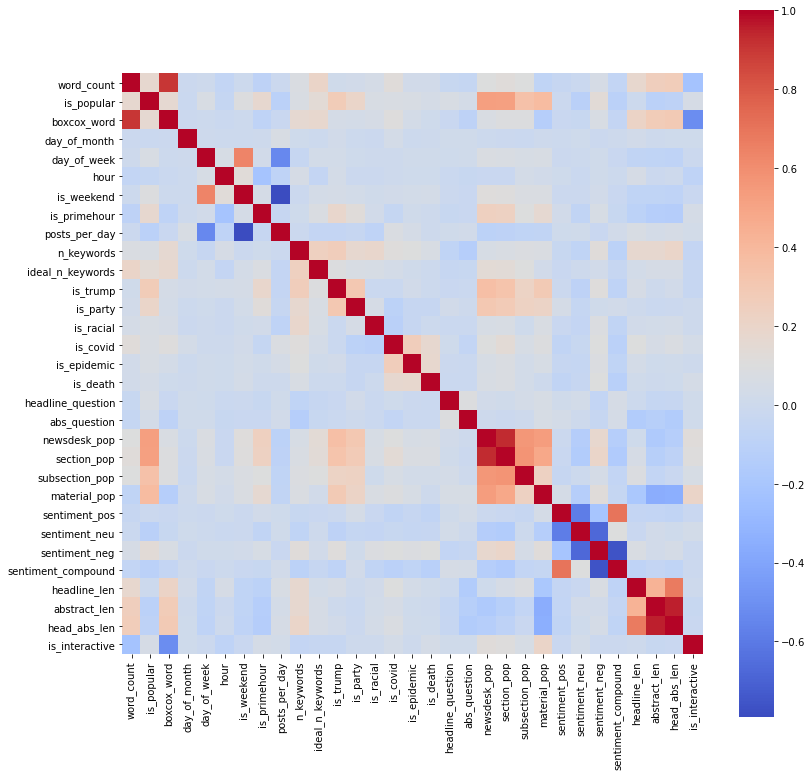

In [60]:
plt.figure(figsize=(13,13))
sns.heatmap(train.corr(), cmap='coolwarm', annot=False, square=True, fmt='.2f', cbar=True)

In [61]:
top_feats = abs(train._get_numeric_data().corr()['is_popular']).sort_values(ascending=False).index[0:42]

In [62]:
# We're dropping mostly our text columns, some clusters, headline_len, day_of_month and abs_question
print([col for col in train.columns if col not in top_feats])

['newsdesk', 'section', 'subsection', 'material', 'headline', 'abstract', 'keywords', 'pub_date', 'uniqueID', 'group_date', 'combi_text', 'combi_text2']


In [63]:
pd.concat([train, test]).to_csv('./datasets/full_processed.csv', index=False)

In [64]:
train = train[top_feats]
test = test[top_feats]

<AxesSubplot:>

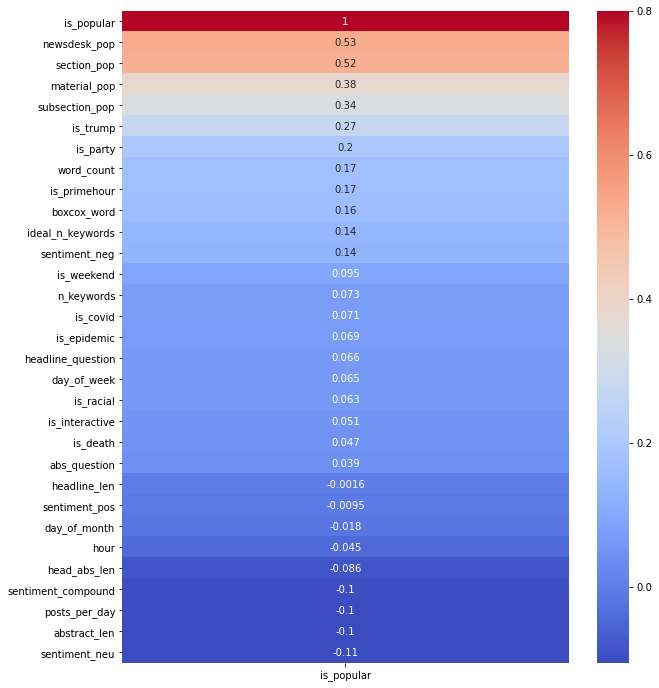

In [65]:
plt.figure(figsize=(10,12))
sns.heatmap(train.corr()[['is_popular']].sort_values(ascending=False, by='is_popular'), 
            cmap='coolwarm', annot=True, vmax=0.8)

In [66]:
train.to_csv('./datasets/train_processed.csv', index=False)

In [67]:
test.to_csv('./datasets/test_processed.csv', index=False)